In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
import pandas as pd

df_SpamAssasin = pd.read_csv('../data/SpamAssasin.csv')
df_Nigerian_Fraud = pd.read_csv('../data/Nigerian_Fraud.csv')
df_phishing_email = pd.read_csv('../data/phishing_email.csv')
df_CEAS_08 = pd.read_csv('../data/CEAS_08.csv')
df_Enron = pd.read_csv('../data/Enron.csv')
df_Ling = pd.read_csv('../data/Ling.csv')
df_Nazario = pd.read_csv('../data/Nazario.csv')

# Get basic information about the datasets
df_SpamAssasin.info()
df_Nigerian_Fraud.info()
df_phishing_email.info()
df_CEAS_08.info()
df_Enron.info()
df_Ling.info()
df_Nazario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5809 entries, 0 to 5808
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    5809 non-null   object
 1   receiver  5599 non-null   object
 2   date      5809 non-null   object
 3   subject   5793 non-null   object
 4   body      5808 non-null   object
 5   label     5809 non-null   int64 
 6   urls      5809 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 317.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3332 entries, 0 to 3331
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    3001 non-null   object
 1   receiver  2008 non-null   object
 2   date      2850 non-null   object
 3   subject   3293 non-null   object
 4   body      3332 non-null   object
 5   urls      3332 non-null   int64 
 6   label     3332 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 182.3+ KB


In [7]:
df_Nazario = df_Nazario[df_CEAS_08.columns]
df_Nigerian_Fraud = df_Nigerian_Fraud[df_CEAS_08.columns]
df = pd.concat([df_CEAS_08, df_Nazario, df_Nigerian_Fraud], ignore_index=True)
df.shape

(44051, 7)

In [8]:
df.isnull().sum()

sender       331
receiver    1882
date         483
subject       71
body           0
label          0
urls           0
dtype: int64

In [9]:
# Drop rows where any column has a null value
df = df.dropna(how='any')

# Display the shape to see how many rows are left and check the result
df.shape

(41708, 7)

In [10]:
df.duplicated().sum()
df=df.drop_duplicates()

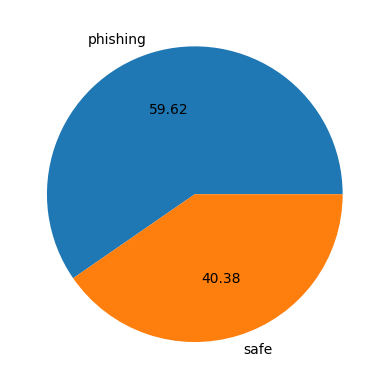

In [11]:
df['label'].value_counts()
import matplotlib.pyplot as plt
plt.pie(df['label'].value_counts(), labels=['phishing','safe'],autopct="%0.2f")
plt.show()

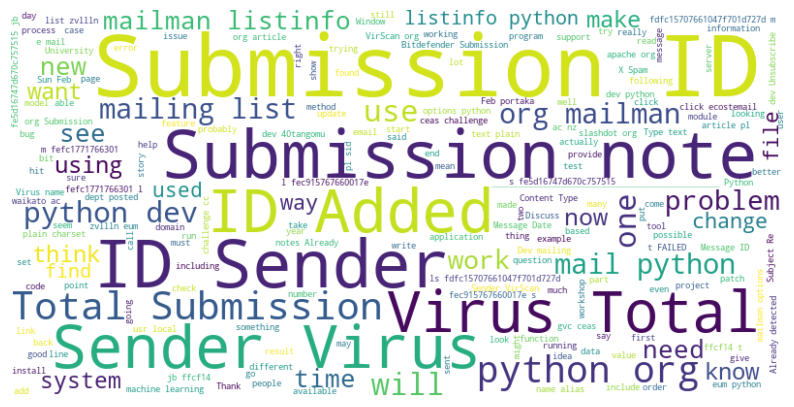

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
safe_email = df[df["label"] == 0]
safe_text = " ".join(safe_email["body"])
word_cloud = WordCloud(width=800,height=400,background_color="white").generate(safe_text)
plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

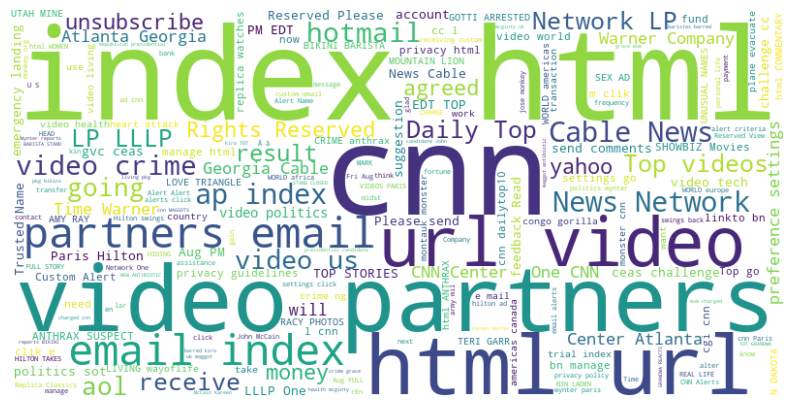

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
phishing_email = df[df["label"] == 1]
phishing_text = " ".join(phishing_email["body"])
word_cloud = WordCloud(width=800,height=400,background_color="white").generate(phishing_text)
plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [15]:
import re

# Define a function to extract URLs from text
def extract_urls(text):
    # Regex pattern to match URLs
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    # Find all URLs in the text
    urls = re.findall(url_pattern, text)
    
    # Replace URLs in the body with the text 'url'
    text_without_urls = re.sub(url_pattern, 'url', text)
    
    return text_without_urls, urls

# Apply the function to the 'body' column
df['body'], df['extracted_urls'] = zip(*df['body'].apply(extract_urls))

# Check the first few rows to verify the changes
df[['body', 'extracted_urls']].head()

,body,extracted_urls
0,"Buck up, your troubles caused by small dimensi...",[http://whitedone.com/]
1,\nUpgrade your sex and pleasures with these te...,[http://www.brightmade.com]
2,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,[http://www.cnn.com/video/partners/email/index...
3,Would anyone object to removing .so from this ...,[http://en.wikipedia.org/wiki/.so_%28domain_na...
4,\nWelcomeFastShippingCustomerSupport\nurl\n\n\n,[http://7iwfna.blu.livefilestore.com/y1pXdX3kw...


In [16]:
df['extracted_urls'].describe()

count     41708
unique    11599
top          []
freq      15203
Name: extracted_urls, dtype: object

In [17]:
# 2. Feature Engineering

# Feature 1: URLs - Number of URLs present in the email
df['num_urls'] = df['extracted_urls'].apply(len)

# Feature 2: Email Metadata - Extract domain from sender's email address
df['sender_domain'] = df['sender'].apply(lambda x: x.split('@')[-1] if '@' in x else 'unknown')

# Feature 3: Length Features
df['body_length'] = df['body'].apply(len)

In [18]:
df.head()

,sender,receiver,date,subject,body,label,urls,extracted_urls,num_urls,sender_domain,body_length
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,[http://whitedone.com/],1,iworld.de>,255
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,[http://www.brightmade.com],1,icable.ph>,60
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,[http://www.cnn.com/video/partners/email/index...,24,universalnet.psi.br>,2066
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,[http://en.wikipedia.org/wiki/.so_%28domain_na...,467,pobox.com>,16097
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nurl\n\n\n,1,1,[http://7iwfna.blu.livefilestore.com/y1pXdX3kw...,1,loanofficertool.com>,42


In [20]:
# Filter rows where 'extracted_urls' is empty
df_empty_urls = df[df['extracted_urls'].apply(lambda x: len(x) == 0)]

# Filter rows where 'extracted_urls' is non-empty
df_non_empty_urls = df[df['extracted_urls'].apply(lambda x: len(x) > 0)]

# Randomly sample 500 from each
df_empty_urls_sampled = df_empty_urls.sample(n=500, random_state=42)
df_non_empty_urls_sampled = df_non_empty_urls.sample(n=500, random_state=42)

# Concatenate the two samples to get 1000 rows
df_balanced_sample = pd.concat([df_empty_urls_sampled, df_non_empty_urls_sampled])

# Shuffle the combined DataFrame to mix the rows
df_balanced_sample = df_balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows of the balanced sample
df_balanced_sample.head()
df=df_balanced_sample

In [36]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from string import punctuation

# Download the required NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Initialize the stop words and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Define a function for text preprocessing
def preprocess_text(text):
    # 1. Convert to lowercase
    text = text.lower()
    
    # 2. Tokenization
    tokens = word_tokenize(text)
    
    # 3. Remove special characters and numbers
    tokens = [re.sub(r'[^a-zA-Z]', '', word) for word in tokens]
    
    # 4. Remove stop words and punctuation
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation and word]
    
    # 5. Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Join tokens back into a single string
    return ' '.join(tokens)

# Apply the preprocessing to the 'subject' and 'body' columns
df['subject'] = df['subject'].fillna('').apply(preprocess_text)
df['body'] = df['body'].fillna('').apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


KeyError: 'subject'

In [23]:
df.head()

,sender,receiver,date,subject,body,label,urls,extracted_urls,num_urls,sender_domain,body_length
0,bill.nelson@sistinatravel.it,user8.2-ext2@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 13:54:29 +0530",This is for you.,\nYour neighbour is delivering you an Ecard fr...,1,1,[http://YourLettercard.com/?31ad8eb1d97],1,sistinatravel.it,147
1,Daily Top 10 <espeiste_1961@ohiodominican.edu>,email1005@gvc.ceas-challenge.cc,"Thu, 07 Aug 2008 05:17:16 -0500",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,[http://www.cnn.com/video/partners/email/index...,24,ohiodominican.edu>,2076
2,Dunham <>,user8.2@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 05:08:18 +0400",Psychologist endorsed products for men,"\nBang her with all your might, renew your mig...",1,1,"[http://www.fiftyday.com/, http://www.opera.co...",2,unknown,129
3,majcen <>,user7@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 04:14:49 +0100",Psychologist endorsed products for men,\nMen who ignore this report will regret\nurl\...,1,1,"[http://www.fiftywin.com/, http://www.opera.co...",2,unknown,97
4,Morgan Romero <lwjorchestra@cablevision.qc.ca>,user2.4@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 16:27:19 -0500","More length, hardness and strength",\n\n\nCasanova style of life.\n\n\nTurn it to ...,1,0,[],0,cablevision.qc.ca>,204


In [24]:
import pandas as pd
import re
from urllib.parse import urlparse

# Function to extract features from a URL
def extract_url_features(url):
    features = []
    
    # Feature 1: Check if URL starts with "https" (phishing links often don't use https)
    features.append(1 if url.lower().startswith("https") else 0)

    # Feature 2: Length of URL (phishing URLs tend to be longer)
    features.append(len(url))

    # Feature 3: Number of subdomains in the URL (phishing URLs often have multiple subdomains)
    parsed_url = urlparse(url)
    subdomain_count = len(parsed_url.netloc.split('.')) - 2  # Subdomains count, excluding domain and TLD
    features.append(subdomain_count)

    # Feature 4: Check if URL contains suspicious keywords like "login", "verify", etc.
    suspicious_keywords = ["login", "verify", "account", "secure", "update", "password"]
    features.append(1 if any(keyword in url.lower() for keyword in suspicious_keywords) else 0)

    # Feature 5: Number of URL parameters (phishing sites often have multiple parameters)
    features.append(url.count('?'))

    return features

# Function to process extracted URLs for each row and generate aggregated feature vectors
def extract_features_from_urls(urls):
    all_features = []
    
    # Iterate over each URL in the list of URLs
    for url in urls:
        features = extract_url_features(url)
        all_features.append(features)
    
    # If there are multiple URLs, aggregate the features (average the numeric ones)
    if all_features:
        aggregated_features = []
        for i in range(len(all_features[0])):  # Iterate over each feature
            if isinstance(all_features[0][i], (int, float)):  # Check if the feature is numeric
                aggregated_features.append(sum(f[i] for f in all_features) / len(all_features))
            else:
                # Handle non-numeric features (e.g., suspicious keywords)
                aggregated_features.append(None)  # Use None for non-numeric features
        return aggregated_features
    else:
        # Return default vector (zeros) if there are no URLs
        return [0] * 5  # 5 features as defined earlier

# Example usage with your existing dataframe
df['extracted_urls'] = df['extracted_urls'].apply(extract_features_from_urls)

# Print the updated dataframe to verify the changes
print(df[['sender', 'extracted_urls']].head())

                                           sender  \
0                    bill.nelson@sistinatravel.it   
1  Daily Top 10 <espeiste_1961@ohiodominican.edu>   
2                                       Dunham <>   
3                                       majcen <>   
4  Morgan Romero <lwjorchestra@cablevision.qc.ca>   

                                      extracted_urls  
0                         [0.0, 38.0, 0.0, 0.0, 1.0]  
1  [0.0, 78.125, 1.0, 0.041666666666666664, 0.458...  
2                         [0.0, 25.0, 1.0, 0.0, 0.0]  
3                         [0.0, 25.0, 1.0, 0.0, 0.0]  
4                                    [0, 0, 0, 0, 0]  


In [25]:
df.head()

,sender,receiver,date,subject,body,label,urls,extracted_urls,num_urls,sender_domain,body_length
0,bill.nelson@sistinatravel.it,user8.2-ext2@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 13:54:29 +0530",This is for you.,\nYour neighbour is delivering you an Ecard fr...,1,1,"[0.0, 38.0, 0.0, 0.0, 1.0]",1,sistinatravel.it,147
1,Daily Top 10 <espeiste_1961@ohiodominican.edu>,email1005@gvc.ceas-challenge.cc,"Thu, 07 Aug 2008 05:17:16 -0500",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,"[0.0, 78.125, 1.0, 0.041666666666666664, 0.458...",24,ohiodominican.edu>,2076
2,Dunham <>,user8.2@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 05:08:18 +0400",Psychologist endorsed products for men,"\nBang her with all your might, renew your mig...",1,1,"[0.0, 25.0, 1.0, 0.0, 0.0]",2,unknown,129
3,majcen <>,user7@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 04:14:49 +0100",Psychologist endorsed products for men,\nMen who ignore this report will regret\nurl\...,1,1,"[0.0, 25.0, 1.0, 0.0, 0.0]",2,unknown,97
4,Morgan Romero <lwjorchestra@cablevision.qc.ca>,user2.4@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 16:27:19 -0500","More length, hardness and strength",\n\n\nCasanova style of life.\n\n\nTurn it to ...,1,0,"[0, 0, 0, 0, 0]",0,cablevision.qc.ca>,204


In [26]:
df['text'] = df['subject'] + " " + df['body']

In [27]:
phishing_corpus = []
for msg in df[df['label'] == 1]['text'].tolist():
    for word in msg.split():
        if word=="url":
            continue
        phishing_corpus.append(word)
len(phishing_corpus)

73310

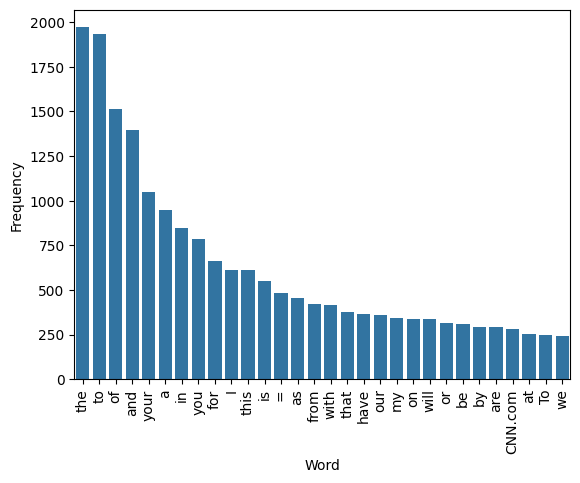

In [29]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'phishing_corpus' is a list or iterable containing the words
phishing_corpus_counter = Counter(phishing_corpus).most_common(30)

# Create a DataFrame from the Counter object
dff = pd.DataFrame(phishing_corpus_counter, columns=['Word', 'Frequency'])

# Plot the barplot
sns.barplot(x='Word', y='Frequency', data=dff)

# Rotate x-axis labels for better readability
plt.xticks(rotation='vertical')

# Show the plot
plt.show()

In [30]:
df.head()

,sender,receiver,date,subject,body,label,urls,extracted_urls,num_urls,sender_domain,body_length,text
0,bill.nelson@sistinatravel.it,user8.2-ext2@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 13:54:29 +0530",This is for you.,\nYour neighbour is delivering you an Ecard fr...,1,1,"[0.0, 38.0, 0.0, 0.0, 1.0]",1,sistinatravel.it,147,This is for you. \nYour neighbour is deliverin...
1,Daily Top 10 <espeiste_1961@ohiodominican.edu>,email1005@gvc.ceas-challenge.cc,"Thu, 07 Aug 2008 05:17:16 -0500",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,"[0.0, 78.125, 1.0, 0.041666666666666664, 0.458...",24,ohiodominican.edu>,2076,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...
2,Dunham <>,user8.2@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 05:08:18 +0400",Psychologist endorsed products for men,"\nBang her with all your might, renew your mig...",1,1,"[0.0, 25.0, 1.0, 0.0, 0.0]",2,unknown,129,Psychologist endorsed products for men \nBang ...
3,majcen <>,user7@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 04:14:49 +0100",Psychologist endorsed products for men,\nMen who ignore this report will regret\nurl\...,1,1,"[0.0, 25.0, 1.0, 0.0, 0.0]",2,unknown,97,Psychologist endorsed products for men \nMen w...
4,Morgan Romero <lwjorchestra@cablevision.qc.ca>,user2.4@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 16:27:19 -0500","More length, hardness and strength",\n\n\nCasanova style of life.\n\n\nTurn it to ...,1,0,"[0, 0, 0, 0, 0]",0,cablevision.qc.ca>,204,"More length, hardness and strength \n\n\nCasan..."


In [31]:
# Drop the specified columns
df = df.drop(columns=['sender', 'receiver', 'date','subject','body','sender_domain'])

# Verify the changes
df.head()

,label,urls,extracted_urls,num_urls,body_length,text
0,1,1,"[0.0, 38.0, 0.0, 0.0, 1.0]",1,147,This is for you. \nYour neighbour is deliverin...
1,1,1,"[0.0, 78.125, 1.0, 0.041666666666666664, 0.458...",24,2076,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...
2,1,1,"[0.0, 25.0, 1.0, 0.0, 0.0]",2,129,Psychologist endorsed products for men \nBang ...
3,1,1,"[0.0, 25.0, 1.0, 0.0, 0.0]",2,97,Psychologist endorsed products for men \nMen w...
4,1,0,"[0, 0, 0, 0, 0]",0,204,"More length, hardness and strength \n\n\nCasan..."


In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Assuming your dataframe is already loaded and preprocessed
# Let's assume 'df' is your dataframe

# 1. Separate the features and target variable
X = df.drop(columns=['label'])
y = df['label']

# 2. Text Preprocessing (TF-IDF)
# Combine subject and body text into one column for modeling
# Since you already have the 'text' field, we will use that

# 3. Column Transformer to apply different transformations
# Apply TF-IDF vectorizer on the 'text' column
# Standardize numerical columns like num_urls and body_length
# Use FunctionTransformer for 'extracted_urls' as it is a list of features

def extract_url_features(url_features):
    # Flatten the extracted_urls list into numerical vectors (or some other strategy)
    return np.array(url_features) if isinstance(url_features, list) else np.zeros(5)

# Apply transformations
column_transformer = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', max_features=5000), 'text'),  # TF-IDF for text
        ('num', StandardScaler(), ['num_urls', 'body_length']),  # Standard scale for numerical columns
        ('url_features', FunctionTransformer(lambda x: np.array([extract_url_features(f) for f in x])), 'extracted_urls')  # Process extracted_urls
    ],
    remainder='passthrough'  # Keep other columns like 'sender', 'receiver', etc. as is
)

# 4. Define the pipeline with the classifier
model = Pipeline(steps=[
    ('preprocessor', column_transformer),  # Apply the transformations
    ('classifier', LogisticRegression(max_iter=1000))  # Logistic Regression as the classifier
])

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Cross-Validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Accuracy:", np.mean(cv_scores))

# 7. Hyperparameter Tuning with GridSearchCV
# Parameter grid for logistic regression
param_grid = {
    'classifier__C': [0.1, 1, 10],  # Regularization strength for Logistic Regression
    'classifier__solver': ['lbfgs', 'liblinear'],  # Solvers to test
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print best parameters from GridSearchCV
print("Best Parameters from GridSearchCV:", grid_search.best_params_)

# 8. Final Model Evaluation
# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predict the labels for the test set using the best model
y_pred = best_model.predict(X_test)

# Print classification metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optionally, you can also print accuracy
accuracy = np.mean(y_pred == y_test)
print("Test Accuracy:", accuracy)

Cross-Validation Scores: [0.925   0.9     0.925   0.96875 0.95   ]
Average Cross-Validation Accuracy: 0.9337500000000001
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters from GridSearchCV: {'classifier__C': 10, 'classifier__solver': 'lbfgs'}
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.97        88
           1       0.96      0.99      0.97       112

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200

Confusion Matrix:
 [[ 83   5]
 [  1 111]]
Test Accuracy: 0.97


In [33]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Define the BernoulliNB model
gnb = BernoulliNB()

# Function to convert sparse matrix to dense
def to_dense(X):
    return X.toarray()

# Update your column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('text', Pipeline([
            ('vectorizer', TfidfVectorizer(stop_words='english', max_features=5000)),  # TF-IDF for text
            ('to_dense', FunctionTransformer(to_dense))  # Convert sparse matrix to dense
        ]), 'text'),  # Apply TF-IDF and then convert to dense
        ('num', StandardScaler(), ['num_urls', 'body_length']),  # Standard scale for numerical columns
        ('url_features', FunctionTransformer(lambda x: np.array([extract_url_features(f) for f in x])), 'extracted_urls')  # Process extracted_urls
    ],
    remainder='passthrough'  # Keep other columns like 'sender', 'receiver', etc. as is
)

# Define the pipeline with BernoulliNB as the classifier
model = Pipeline(steps=[
    ('preprocessor', column_transformer),  # Apply the transformations
    ('classifier', gnb)  # Use BernoulliNB as the classifier
])

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Cross-Validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Accuracy:", np.mean(cv_scores))

# 7. Hyperparameter Tuning with GridSearchCV
param_grid = {
    'classifier__alpha': [0.1, 1, 10],  # Hyperparameter for BernoulliNB
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print best parameters from GridSearchCV
print("Best Parameters from GridSearchCV:", grid_search.best_params_)

# 8. Final Model Evaluation
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Print classification metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optionally, you can also print accuracy
accuracy = np.mean(y_pred == y_test)
print("Test Accuracy:", accuracy)

Cross-Validation Scores: [0.88125 0.9375  0.9     0.93125 0.90625]
Average Cross-Validation Accuracy: 0.9112500000000001
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters from GridSearchCV: {'classifier__alpha': 0.1}
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92        88
           1       0.90      0.99      0.94       112

    accuracy                           0.94       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.94      0.94      0.93       200

Confusion Matrix:
 [[ 76  12]
 [  1 111]]
Test Accuracy: 0.935


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
import numpy as np
import xgboost as xgb

# Function to convert sparse matrix to dense
def to_dense(X):
    return X.toarray()

# Function to extract url features (Placeholder)
def extract_url_features(url_features):
    return np.array(url_features) if isinstance(url_features, list) else np.zeros(5)

# Prepare your data (assuming 'df' is already loaded)
X = df.drop(columns=['label'])
y = df['label']

# Define your column transformer for preprocessing
column_transformer = ColumnTransformer(
    transformers=[
        ('text', Pipeline([
            ('vectorizer', TfidfVectorizer(stop_words='english', max_features=5000)),  # TF-IDF for text
            ('to_dense', FunctionTransformer(to_dense))  # Convert sparse matrix to dense
        ]), 'text'),
        ('num', StandardScaler(), ['num_urls', 'body_length']),  # Standard scale for numerical columns
        ('url_features', FunctionTransformer(lambda x: np.array([extract_url_features(f) for f in x])), 'extracted_urls')  # Process extracted_urls
    ],
    remainder='passthrough'  # Keep other columns as is
)

# Define models and parameter grids to compare
models_and_params = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'param_grid': {
            'classifier__C': [0.1, 1, 10],
            'classifier__solver': ['lbfgs', 'liblinear']
        }
    },
    'Bernoulli Naive Bayes': {
        'model': BernoulliNB(),
        'param_grid': {}
    },
    'Gaussian Naive Bayes': {
        'model': GaussianNB(),
        'param_grid': {}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'param_grid': {
            'classifier__max_depth': [10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=42),
        'param_grid': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 1]
        }
    },
    'Bagging': {
        'model': BaggingClassifier(random_state=42),
        'param_grid': {
            'classifier__n_estimators': [50, 100, 200]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'param_grid': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__max_depth': [3, 5]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        'param_grid': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__max_depth': [3, 5]
        }
    }
}

# Prepare a list to hold results
results = []

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Iterate over models, train them, perform GridSearchCV, and evaluate
for model_name, model_and_params in models_and_params.items():
    model = model_and_params['model']
    param_grid = model_and_params['param_grid']
    
    # Define the pipeline with the classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', column_transformer),  # Apply transformations
        ('classifier', model)  # Use model in pipeline
    ])
    
    # If there is a parameter grid, perform GridSearchCV
    if param_grid:
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best Parameters for {model_name}: {best_params}")
        
        # Cross-Validation: Compute accuracy
        cv_accuracy = grid_search.best_score_
    else:
        # No hyperparameter tuning, just use cross_val_score
        cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
        best_model = pipeline.fit(X_train, y_train)  # Fit the pipeline without GridSearch
        
    # Compute precision on the test set
    y_pred_test = best_model.predict(X_test)
    test_precision = precision_score(y_test, y_pred_test, average='macro')  # Use 'macro' for multi-class precision
    
    # Store results in the list
    results.append({
        'Algorithm': model_name,
        'Accuracy': cv_accuracy,
        'Precision': test_precision
    })

# Create a DataFrame to display results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters for Logistic Regression: {'classifier__C': 10, 'classifier__solver': 'liblinear'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for Decision Tree: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters for Random Forest: {'classifier__max_depth': 30, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for AdaBoost: {'classifier__learning_rate': 1, 'classifier__n_estimators': 200}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters for Bagging: {'classifier__n_estimators': 50}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for Gradient Boosting: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Fitting 5 fol

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:06:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
               Algorithm  Accuracy  Precision
0    Logistic Regression   0.96250   0.976726
1  Bernoulli Naive Bayes   0.91125   0.908759
2   Gaussian Naive Bayes   0.93250   0.921369
3          Decision Tree   0.91000   0.919779
4          Random Forest   0.95875   0.937999
5               AdaBoost   0.95750   0.930390
6                Bagging   0.93500   0.926649
7      Gradient Boosting   0.95250   0.922994
8                XGBoost   0.95875   0.948508



Voting Classifier (Logistic, Random Forest, XGBoost) Final Accuracy: 0.9450
Voting Classifier (Logistic, Random Forest, XGBoost) Final Precision: 0.9523


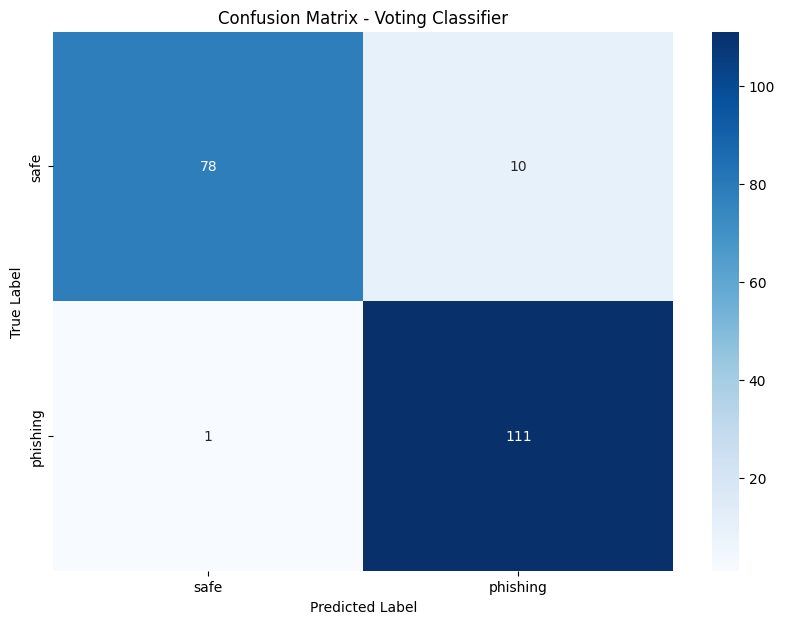

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

# Define best classifiers for Logistic Regression, Random Forest, and XGBoost with their best parameters
logistic_regression_best = LogisticRegression(max_iter=1000, C=10, solver='lbfgs')
random_forest_best = RandomForestClassifier(max_depth=30, min_samples_split=2, n_estimators=100, random_state=42)
xgboost_best = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)

# Create the Voting Classifier with the best classifiers
voting_clf = VotingClassifier(estimators=[
    ('Logistic Regression', logistic_regression_best),
    ('Random Forest', random_forest_best),
    ('XGBoost', xgboost_best)
], voting='hard')

# Define the pipeline with the preprocessor and VotingClassifier
pipeline_with_voting = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('voting_classifier', voting_clf)
])

# Train the VotingClassifier
pipeline_with_voting.fit(X_train, y_train)

# Predict on the test set
y_pred_test_voting = pipeline_with_voting.predict(X_test)

# Evaluate the performance of the VotingClassifier
final_accuracy = accuracy_score(y_test, y_pred_test_voting)
final_precision = precision_score(y_test, y_pred_test_voting, average='macro')  # Using 'macro' for multi-class
final_confusion_matrix = confusion_matrix(y_test, y_pred_test_voting)

# Display final evaluation results
print(f"\nVoting Classifier (Logistic, Random Forest, XGBoost) Final Accuracy: {final_accuracy:.4f}")
print(f"Voting Classifier (Logistic, Random Forest, XGBoost) Final Precision: {final_precision:.4f}")

# Define labels for binary classification (phishing and safe)
labels = ['safe', 'phishing']

# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(final_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Voting Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()